In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_roi_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 304)
(631390, 1)
validation
(74368, 304)
(74368, 1)
test
(85358, 304)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1001473 (3.82 MB)


Trainable params: 1001473 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:31 - loss: 0.1133 - STD: 1.6387e-04 - MAE: 0.3245

 5/64 [=>............................] - ETA: 0s - loss: 0.0415 - STD: 1.9876e-04 - MAE: 0.1550  

 9/64 [===>..........................] - ETA: 0s - loss: 0.0384 - STD: 1.4007e-04 - MAE: 0.1522

10/64 [===>..........................] - ETA: 4s - loss: 0.0382 - STD: 1.3127e-04 - MAE: 0.1499

14/64 [=====>........................] - ETA: 3s - loss: 0.0325 - STD: 1.0997e-04 - MAE: 0.1319

18/64 [=======>......................] - ETA: 2s - loss: 0.0284 - STD: 9.8969e-05 - MAE: 0.1229

22/64 [=========>....................] - ETA: 1s - loss: 0.0263 - STD: 9.3672e-05 - MAE: 0.1215

26/64 [===========>..................] - ETA: 1s - loss: 0.0242 - STD: 9.2182e-05 - MAE: 0.1145

30/64 [=============>................] - ETA: 1s - loss: 0.0228 - STD: 9.1938e-05 - MAE: 0.1074

34/64 [==============>...............] - ETA: 0s - loss: 0.0217 - STD: 9.3107e-05 - MAE: 0.1018

38/64 [================>.............] - ETA: 0s - loss: 0.0208 - STD: 9.6010e-05 - MAE: 0.0985

42/64 [==================>...........] - ETA: 0s - loss: 0.0200 - STD: 9.9954e-05 - MAE: 0.0971

46/64 [====================>.........] - ETA: 0s - loss: 0.0194 - STD: 1.0455e-04 - MAE: 0.0954

50/64 [======================>.......] - ETA: 0s - loss: 0.0188 - STD: 1.0958e-04 - MAE: 0.0930

54/64 [========================>.....] - ETA: 0s - loss: 0.0184 - STD: 1.1501e-04 - MAE: 0.0908

58/64 [==========================>...] - ETA: 0s - loss: 0.0180 - STD: 1.2150e-04 - MAE: 0.0893

62/64 [============================>.] - ETA: 0s - loss: 0.0176 - STD: 1.2895e-04 - MAE: 0.0884

64/64 [==============================] - 4s 35ms/step - loss: 0.0175 - STD: 1.3296e-04 - MAE: 0.0879 - val_loss: 0.0167 - val_STD: 2.1986e-04 - val_MAE: 0.0818


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0130 - STD: 2.6671e-04 - MAE: 0.0729

 5/64 [=>............................] - ETA: 0s - loss: 0.0126 - STD: 2.8185e-04 - MAE: 0.0702

 9/64 [===>..........................] - ETA: 0s - loss: 0.0127 - STD: 2.9766e-04 - MAE: 0.0692

13/64 [=====>........................] - ETA: 0s - loss: 0.0126 - STD: 3.1597e-04 - MAE: 0.0692

17/64 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 3.3711e-04 - MAE: 0.0699

21/64 [========>.....................] - ETA: 0s - loss: 0.0126 - STD: 3.5959e-04 - MAE: 0.0700

26/64 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 3.9045e-04 - MAE: 0.0697

30/64 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 4.1891e-04 - MAE: 0.0697

34/64 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 4.5131e-04 - MAE: 0.0699

38/64 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 4.8779e-04 - MAE: 0.0699

42/64 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 5.2918e-04 - MAE: 0.0698

46/64 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 5.7680e-04 - MAE: 0.0697

50/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 6.3276e-04 - MAE: 0.0697

54/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 6.9927e-04 - MAE: 0.0697

58/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 7.7707e-04 - MAE: 0.0697

62/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 8.7151e-04 - MAE: 0.0696

64/64 [==============================] - 1s 17ms/step - loss: 0.0125 - STD: 9.2639e-04 - MAE: 0.0696 - val_loss: 0.0162 - val_STD: 0.0023 - val_MAE: 0.0777


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0125 - STD: 0.0029 - MAE: 0.0693

 5/64 [=>............................] - ETA: 0s - loss: 0.0123 - STD: 0.0032 - MAE: 0.0690

 9/64 [===>..........................] - ETA: 0s - loss: 0.0119 - STD: 0.0037 - MAE: 0.0680

13/64 [=====>........................] - ETA: 0s - loss: 0.0119 - STD: 0.0042 - MAE: 0.0677

17/64 [======>.......................] - ETA: 0s - loss: 0.0118 - STD: 0.0050 - MAE: 0.0675

21/64 [========>.....................] - ETA: 0s - loss: 0.0117 - STD: 0.0059 - MAE: 0.0673

25/64 [==========>...................] - ETA: 0s - loss: 0.0116 - STD: 0.0072 - MAE: 0.0667

29/64 [============>.................] - ETA: 0s - loss: 0.0113 - STD: 0.0089 - MAE: 0.0659

33/64 [==============>...............] - ETA: 0s - loss: 0.0110 - STD: 0.0112 - MAE: 0.0647

37/64 [================>.............] - ETA: 0s - loss: 0.0106 - STD: 0.0142 - MAE: 0.0632

41/64 [==================>...........] - ETA: 0s - loss: 0.0101 - STD: 0.0180 - MAE: 0.0615

45/64 [====================>.........] - ETA: 0s - loss: 0.0096 - STD: 0.0225 - MAE: 0.0597

49/64 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0273 - MAE: 0.0580

53/64 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0319 - MAE: 0.0564

58/64 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.0368 - MAE: 0.0547

62/64 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0405 - MAE: 0.0535

64/64 [==============================] - 1s 17ms/step - loss: 0.0079 - STD: 0.0421 - MAE: 0.0529 - val_loss: 0.0057 - val_STD: 0.0771 - val_MAE: 0.0423


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0944 - MAE: 0.0355

 5/64 [=>............................] - ETA: 0s - loss: 0.0032 - STD: 0.0966 - MAE: 0.0352

 9/64 [===>..........................] - ETA: 0s - loss: 0.0031 - STD: 0.0955 - MAE: 0.0349

13/64 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0347

17/64 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0346

22/64 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0344

26/64 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0972 - MAE: 0.0343

30/64 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0974 - MAE: 0.0341

34/64 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0976 - MAE: 0.0340

38/64 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0977 - MAE: 0.0339

42/64 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0977 - MAE: 0.0338

46/64 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0979 - MAE: 0.0336

50/64 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0981 - MAE: 0.0335

54/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0334

58/64 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0333

62/64 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0986 - MAE: 0.0333

64/64 [==============================] - 1s 16ms/step - loss: 0.0026 - STD: 0.0986 - MAE: 0.0332 - val_loss: 0.0030 - val_STD: 0.0827 - val_MAE: 0.0356


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0323

 5/64 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0320

 9/64 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0317

13/64 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0315

17/64 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0315

21/64 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0315

25/64 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0314

29/64 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0314

33/64 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0313

37/64 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0313

41/64 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0312

45/64 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0312

49/64 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0311

53/64 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0310

57/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0310

61/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0309

64/64 [==============================] - 1s 17ms/step - loss: 0.0021 - STD: 0.1018 - MAE: 0.0308 - val_loss: 0.0023 - val_STD: 0.0834 - val_MAE: 0.0318


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0298

 5/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

 9/64 [===>..........................] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

13/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0297

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

25/64 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

30/64 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

34/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0295

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0294

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0294

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0294

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0293

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0293

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0292

64/64 [==============================] - 1s 16ms/step - loss: 0.0018 - STD: 0.1032 - MAE: 0.0292 - val_loss: 0.0019 - val_STD: 0.0845 - val_MAE: 0.0297


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0284

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

64/64 [==============================] - 1s 17ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282 - val_loss: 0.0018 - val_STD: 0.0840 - val_MAE: 0.0296


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0279

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0279

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0279

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278 - val_loss: 0.0017 - val_STD: 0.0853 - val_MAE: 0.0293


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0277

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276 - val_loss: 0.0018 - val_STD: 0.0843 - val_MAE: 0.0300


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0277

 6/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274 - val_loss: 0.0019 - val_STD: 0.0826 - val_MAE: 0.0314


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

64/64 [==============================] - 1s 17ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273 - val_loss: 0.0017 - val_STD: 0.0853 - val_MAE: 0.0293


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0271

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0848 - val_MAE: 0.0301


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0274

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0270

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0851 - val_MAE: 0.0304


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0271

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0271

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0835 - val_MAE: 0.0299


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0270

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0270

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0270

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0270

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0831 - val_MAE: 0.0312


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0269

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.0834 - val_MAE: 0.0305


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0268

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0846 - val_MAE: 0.0301


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0838 - val_MAE: 0.0298


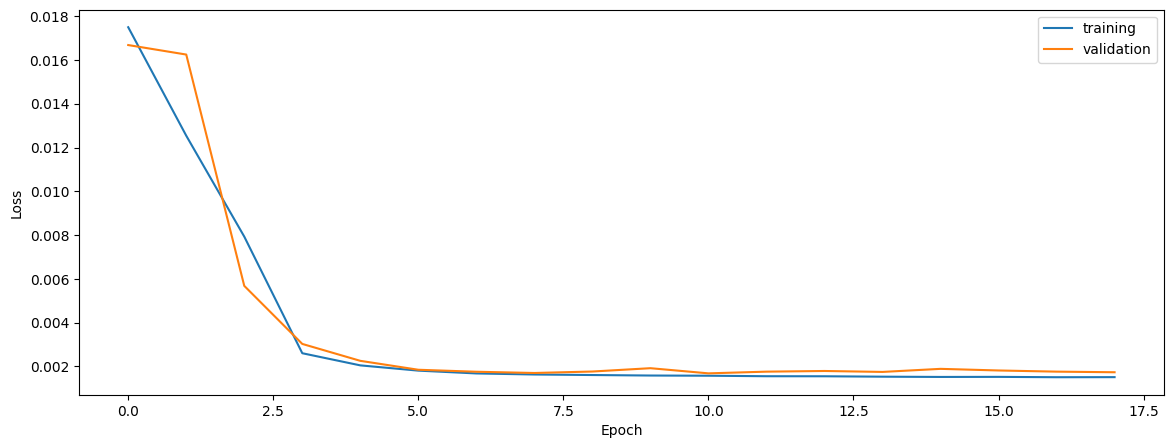

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9368723924160616
0.9486000729101168
0.9281064264990151


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9368723924160616
0.9486000729101168
0.9281064264990151


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9438136622575602
0.9517818390249073
0.9432963956673939


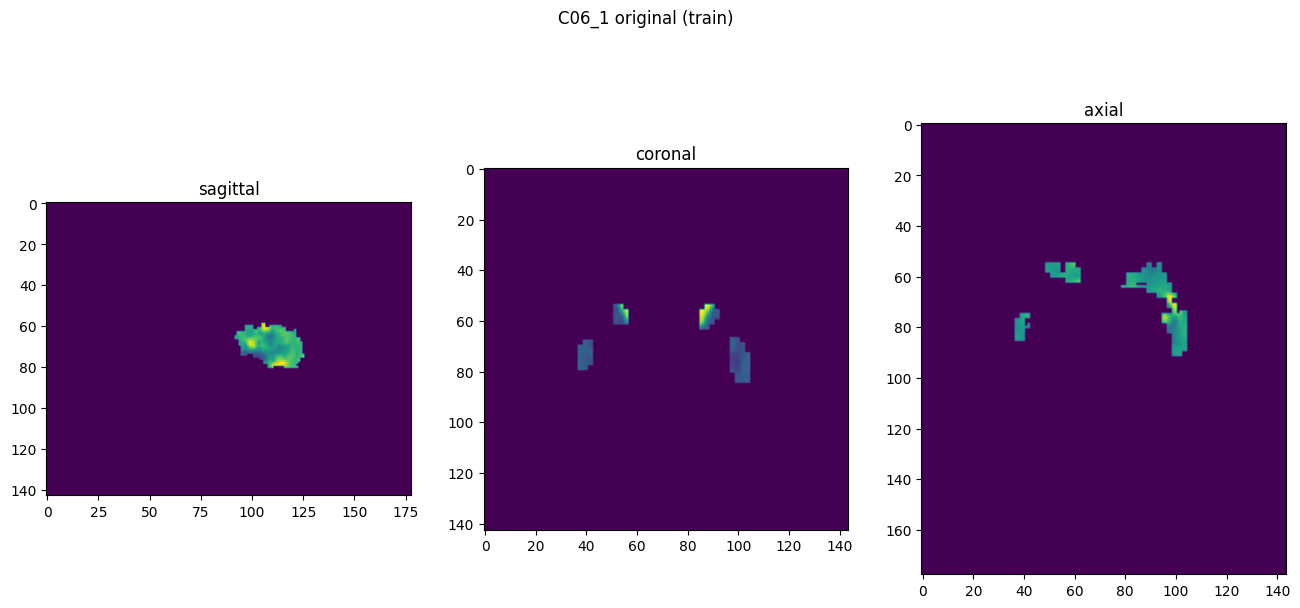

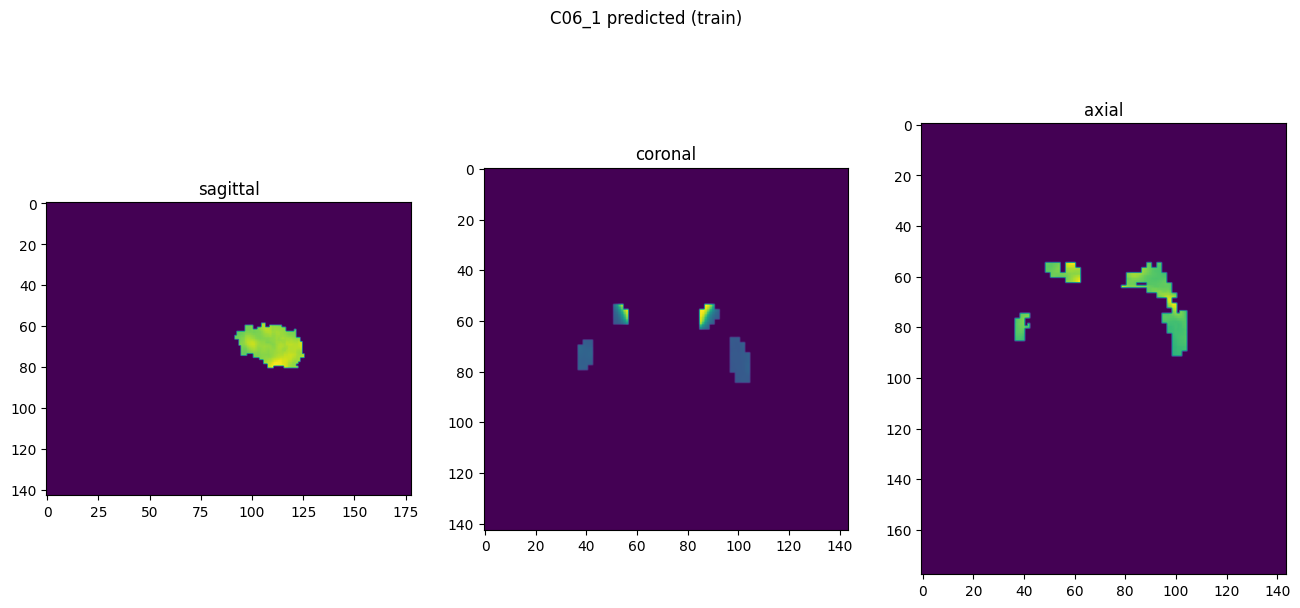

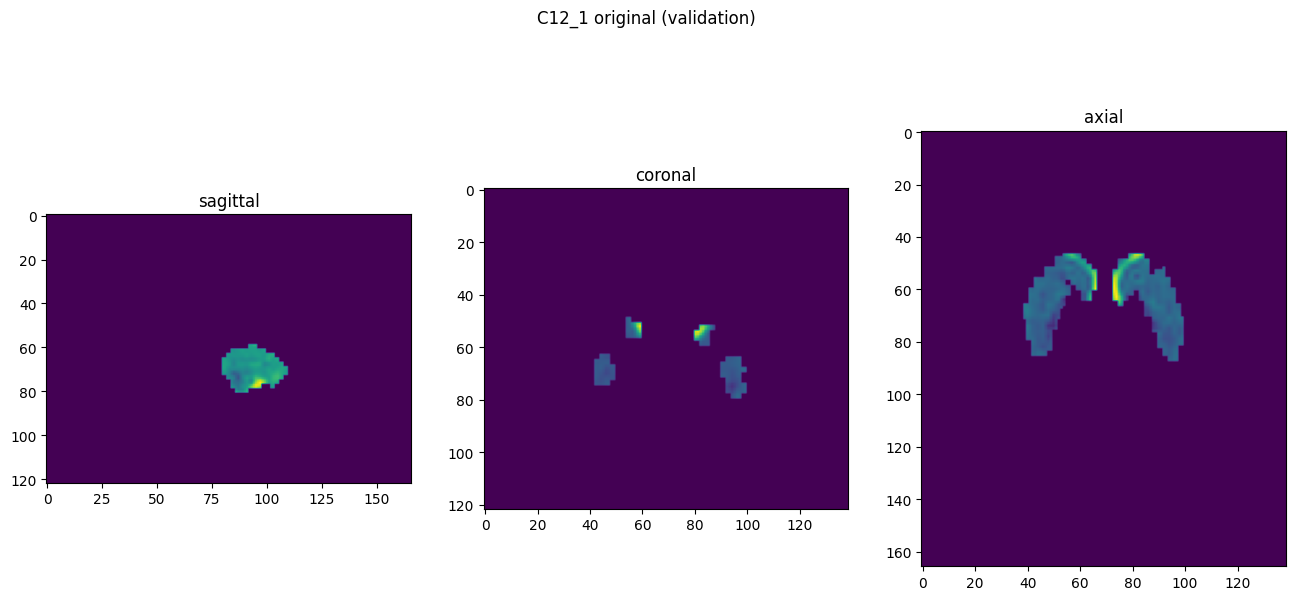

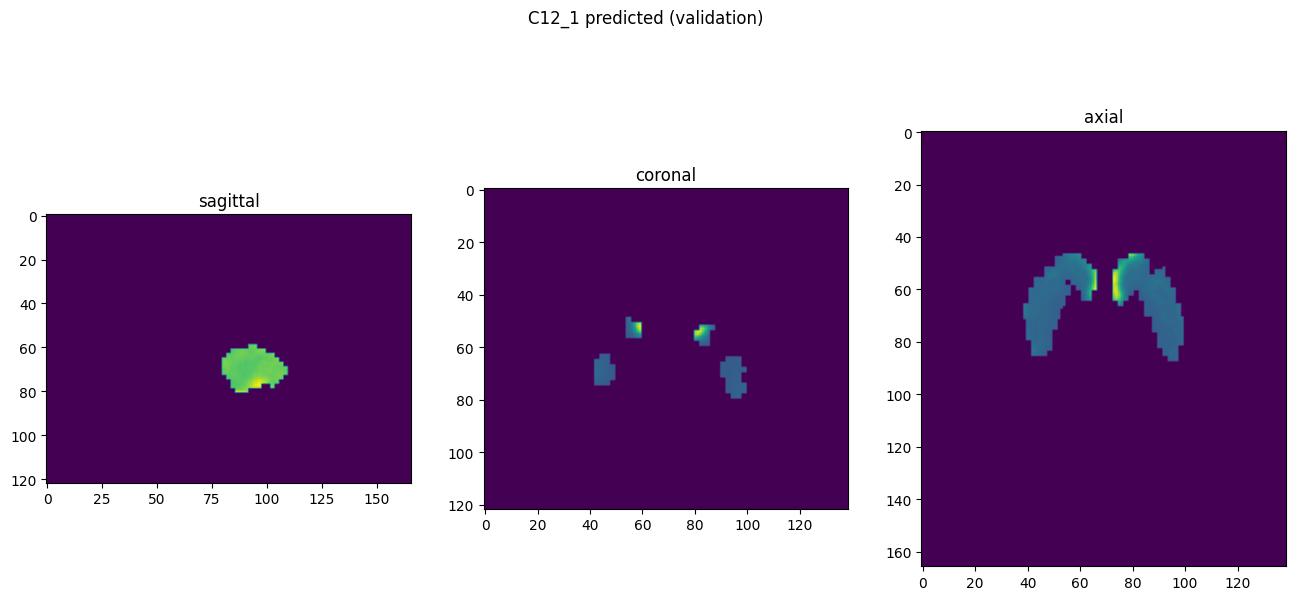

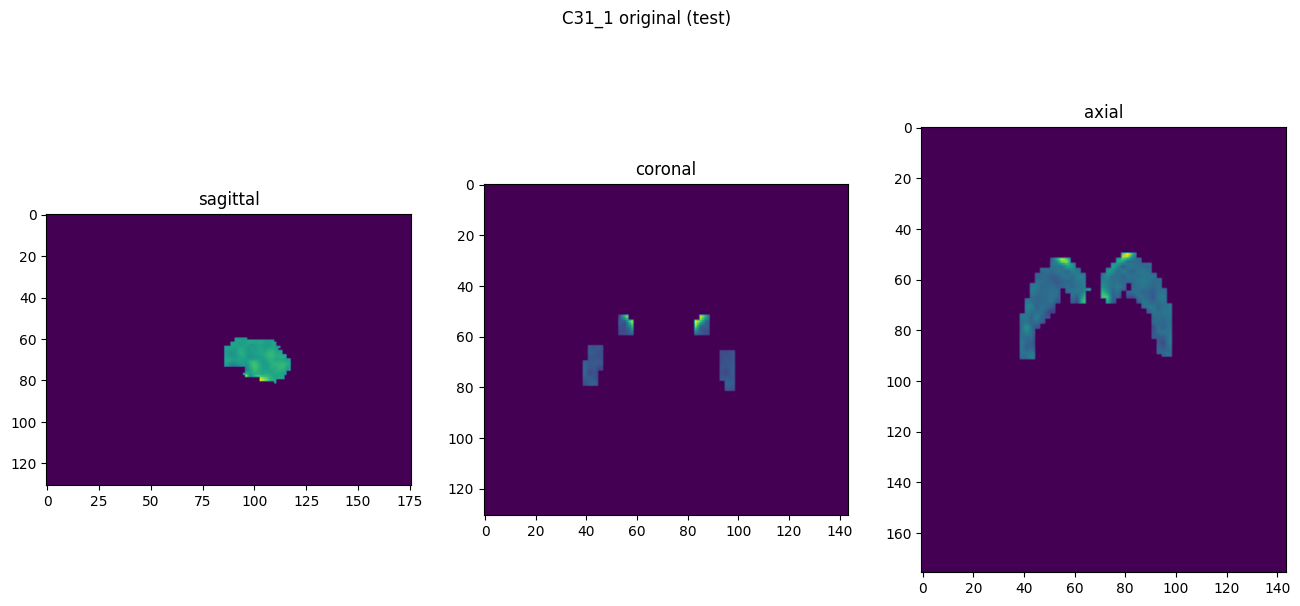

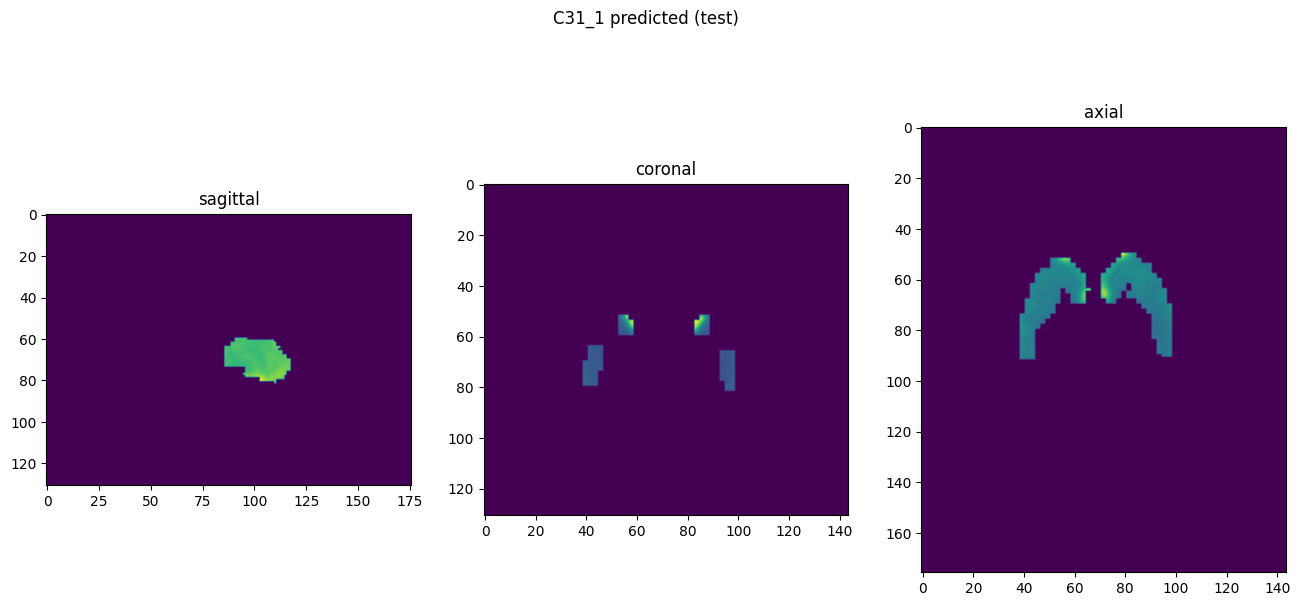

In [10]:
showResults(model, gen, threshold=None, background=False)